# Generative Adverserial Networks

Generative Adverserial Networks (GANs) are generative models in that they create new data instances that resemble our training data. Generative modeling is an **unsupervised** learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

GANs generate a high level of realism in the new data instances that they create by pairing a generator that learns to produce the target output with a discriminator that learns to distinguish true data from the output of the generator. The generator tries to fool the discriminator and the discriminator tries to keep from being fooled.

A **generator** is used to generate new plausible examples from the problem domain. It takes a random distribution as input (typically Gaussian) and outputs some data (typically an image). The random inputs can be thought of as the latent representations (or codings) of the image to be generated. So, generators have the same functionality as decoders in a variational autoencoder and can be used in the same way to generate new images. However, they are trained very differently.    

A **discriminator** is used to classify examples as real (from the domain) or fake (generated). It takes either a fake image from the generator or a real image from the training set as input and guesses whether the input image is fake or real.

During training, the generator and discriminator have opposite goals. The discriminator tries to distinguish fake images from real ones. The generator tries to produce images that look real enough to trick the discriminator.

# Import **tensorflow** library

Import the library and alias it:

In [2]:
import tensorflow as tf

# GPU Hardware Accelerator

To vastly speed up processing, we can use the GPU available from the Google Colab cloud service. Colab provides a free Tesla K80 GPU of about 12 GB. It’s very easy to enable the GPU in a Colab notebook:

1.	click **Runtime** in the top left menu
2.	click **Change runtime** type from the drop-down menu
3.	choose **GPU** from the Hardware accelerator drop-down menu
4.	click **SAVE**

Verify that GPU is active:

In [3]:
tf.__version__, tf.test.gpu_device_name()

('2.12.0', '/device:GPU:0')

# Build a GAN

Load Fashion-MNIST:

In [4]:
import tensorflow_datasets as tfds

x_train_img, _ = tfds.as_numpy(
    tfds.load('fashion_mnist', split='train',
              batch_size=-1, as_supervised=True,
              try_gcs=True, shuffle_files=True))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8U4SRY/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete8U4SRY/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Since we only load train data, it is fine to shuffle.

Number of samples:

In [5]:
len(x_train_img)

60000

Scale:

In [6]:
import numpy as np

images = x_train_img.astype(np.float32) / 255
images.shape

(60000, 28, 28, 1)

Verify scaling worked as expected:

In [7]:
x_train_img[0][0], images[0][0]

(array([[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]], dtype=uint8),
 array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.07058824],
        [0.3019608 ],
        [0.8901961 ],
        [0.8901961 ],
        [0.8156863 ],
        [0.8235294 ],
        [0.88235295],
        [0.84705883],
        [0.33333334],
        [0.1254902 ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.    

Get input shape:

In [8]:
in_shape = images.shape[1:]
in_shape

(28, 28, 1)

## Clear Previous Models and Generate Seed

Clear models and generate seed for reproducibility:

In [9]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Import Libraries

Import requisite libraries:

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,\
  Reshape

## Build the Generator

The generator is similar to an autoencoder's decoder:

In [11]:
codings_size = 30

generator = Sequential([
  Dense(32, activation='selu', input_shape=[codings_size]),
  Dense(64, activation='selu'),
  Dense(128, activation='selu'),
  Dense(28 * 28, activation='sigmoid'),
  Reshape(in_shape)
])

## Build the Discriminator

The discriminator is a regular binary classifier. It takes an image as input and ends with a Dense layer containing a single unit.

In [12]:
discriminator = Sequential([
  Flatten(input_shape=in_shape),
  Dense(128, activation='selu'),
  Dense(64, activation='selu'),
  Dense(32, activation='selu'),
  Dense(1, activation='sigmoid')
])

## Create the GAN Model

Each training iteration is divided into two phases:

* The first phase trains the discriminator. A batch of real images is sampled from the training set and an equal number of fake images is produced by the generator. Labels are set to 0 for fake images and 1 for real images. The discriminator is trained on the labeled batch for one step using binary cross entropy loss. Importantly, backpropagation only optimizes the weights of the discriminator during this phase.
* The second phase trains the generator. We use the generator to produce another batch of fake images and the discriminator is used to distinguish between fake and real images. We don't add real images to the batch and all labels are set to 1 for real. We want the generator to produce images that the discriminator will incorrectly believe to be real! Crucially, weights of the discriminator are frozen during this step so backpropagation only affects weights of the generator.

Create model:

In [13]:
gan = Sequential([generator, discriminator])

## Compile the Discriminator Model

Since the discriminator is naturally a binary classifier (fake or real images), we naturally use binary cross-entropy loss. Since the generator is only trained through the gan model, we don't need to compile it. The gan model is also a binary classifier so it can use the same loss function. Importantly, the discriminator should not be trained during the second phase, so we make it non-trainable before compiling the gan model.

In [14]:
discriminator.compile(
    loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Build the Input Pipeline

Build the pipeline with batch size of 32:

In [15]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(
    images).shuffle(1000)
dataset = dataset.batch(
    batch_size, drop_remainder=True).prefetch(1)

## Create a Custom Loop for Training

Since the training loop is unusual, we can't use the regular fit method. Instead, we create a custom loop that needs a Dataset to iterate through images.  

Create a function for the training loop:

In [16]:
def train_gan(gan, dataset, batch_size,
              codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(
          shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat(
          [generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(
          shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_multiple_images(generated_images, 8)
    plt.show()

Phase one feeds Gaussian noise to the generator to produce fake images, target **y1** is set to 0 for fake and 1 for real images. The discriminator is then trained on the batch. Phase two feeds the GAN some Gaussian noise. Its generator starts by producing fake images. The discriminator then tries to guess if images are fake or real. We want the discriminaor to believe that the fake images are real, so targets **y2** are set to 1.

Humans can easily ignore noise, but machine learning algorithms struggle. Small, human-imperceptible pixel changes, can dramatically alter a neural network's ability to make an accurate prediction. Research has shown that
**noise** and **gaussian blurring** showed near immediate smoothing on tested models.

Resource:

https://blog.roboflow.com/why-to-add-noise-to-images-for-machine-learning/

## Create a Function for Plotting

Create a function to plot images:

In [17]:
import matplotlib.pyplot as plt

def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Generate images with the untrained generator:

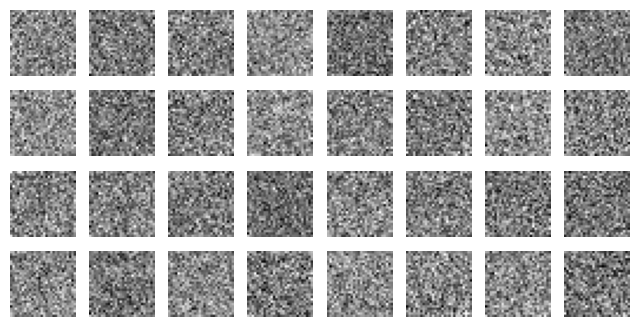

In [18]:
tf.random.set_seed(0)
np.random.seed(0)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Not too impressive:

## Train the GAN

Train the GAN for a few epochs:

Epoch 1/5


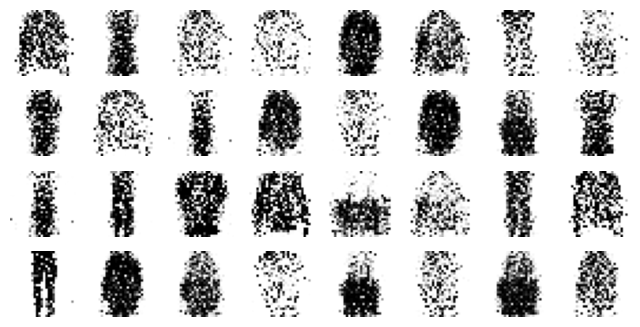

Epoch 2/5


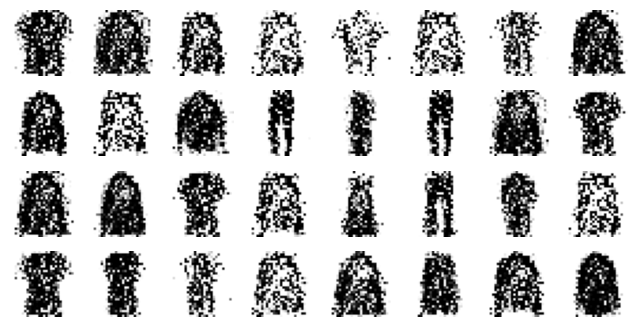

Epoch 3/5


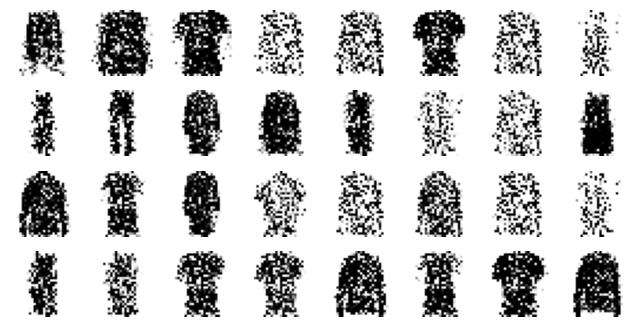

Epoch 4/5


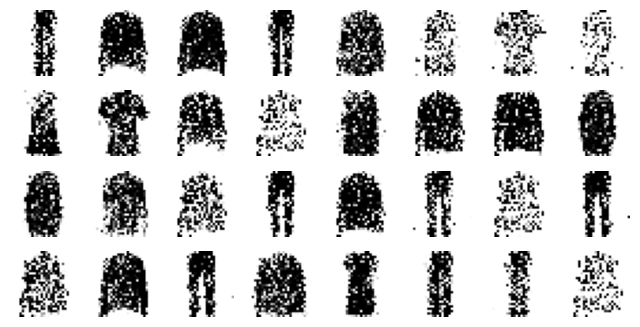

Epoch 5/5


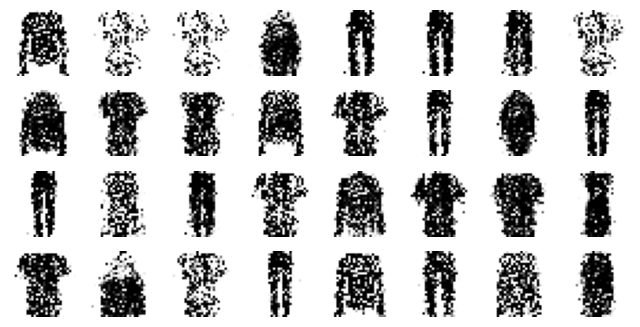

In [19]:
n = 5

train_gan(gan, dataset, batch_size, codings_size, n_epochs=n)

Not great. We trained on 50 epochs. Images improved a little bit.

## Generate Images with the Trained Generator

Add some Gaussian noise and use the generator model to generator some images:

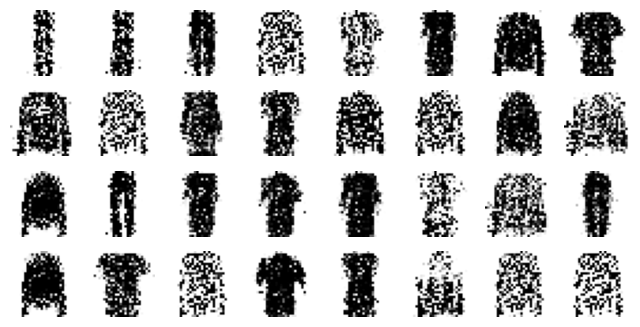

In [20]:
np.random.seed(0)
tf.random.set_seed(0)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

There are 32 images generated because batch size is 32.

Generating a seed ensures that generated images are the same. To generate different images each time, remove the seed:

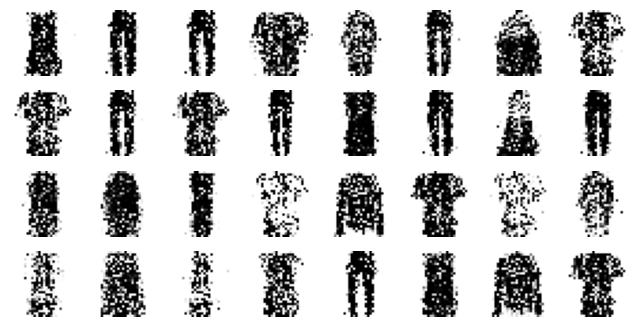

In [21]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

<!-- Train for 10 epochs: -->

# Deep Convolutional GANs (DCGANS)

Using CNN architectures with GANS produces much better results than simple feedforward networks with GANs.

## Create the Generator

Import libraries:

In [22]:
from tensorflow.keras.layers import BatchNormalization,\
  Conv2D, Conv2DTranspose, LeakyReLU, Dropout

Clear previous models and generate seed:

In [23]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

Create the generator:

In [24]:
codings_size = 100

dc_generator = Sequential([
  Dense(7 * 7 * 128, input_shape=[codings_size]),
  Reshape([7, 7, 128]),
  BatchNormalization(),
  Conv2DTranspose(
      64, kernel_size=5, strides=2, padding='SAME',
      activation='selu'),
  BatchNormalization(),
  Conv2DTranspose(
      1, kernel_size=5, strides=2, padding='SAME',
      activation='tanh'),
])

We begin by feeding the generator small tensors (7 x 7 pixels) projected to 128 dimensions resulting in a 6,272 dimensional space. The goal is to increase tensor image size to match Fashion-MNIST images at 28 x 28 and decrease depth to 1 to match the channel size.

The generator accepts codings of size of 100 and projects them to 6,272 dimensions (7 * 7 * 128). The generator then reshapes the projection to a 7 x 7 x 128 tensor, which is batch normalized and fed to a transposed convolutional layer with a stride of 2. The stride upsamples the tensor to 14 x 14 because it doubles the 7 x 7 dimension. The layer also reduces the tensor's depth from 128 to 64. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2. The stride upsamples it to 28 x 28 because it doubles the 14 x 14 dimension. The layer also reduces the tensor's depth from 64 to 1. The output tensor has shape (28, 28, 1), which is our goal because Fashion-MNIST images have shape 28 x 28 x 1. Since the final layer uses tanh activation, outputs are reshaped between the range -1 and 1.

Use the untrained generator to make images:

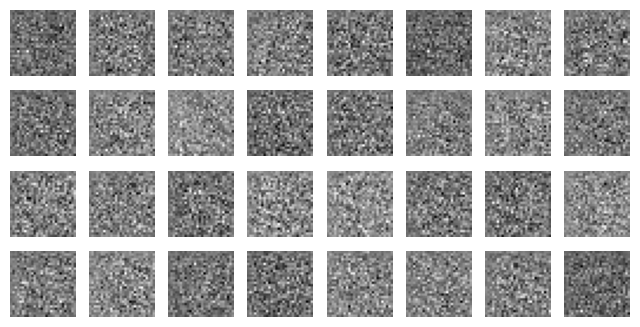

In [25]:
tf.random.set_seed(0)
np.random.seed(0)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = dc_generator(noise)
plot_multiple_images(generated_images, 8)

## Create Discriminator

Create the DCGAN discriminator::

In [26]:
dc_discriminator = Sequential([
  Conv2D(64, kernel_size=5, strides=2, padding='SAME',
         activation=LeakyReLU(0.2),
         input_shape=[28, 28, 1]),
  Dropout(0.4),
  Conv2D(128, kernel_size=5, strides=2, padding='SAME',
         activation=LeakyReLU(0.2)),
  Dropout(0.4),
  Flatten(),
  Dense(1, activation='sigmoid')
])

The discriminator looks like a regular CNN for binary classification (the final Dense layer is 1), except we use strides to downsample instead of max pooling layers.

## Create the DCGAN

Create the DCGAN from the DCGAN generator and discriminator:

In [27]:
dcgan = Sequential([dc_generator, dc_discriminator])

## Compile

Compile the DCGAN:

In [28]:
dc_discriminator.compile(
    loss='binary_crossentropy', optimizer='rmsprop')
dc_discriminator.trainable = False
dcgan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## Reshape

Since outputs range from -1 to 1 due to tanh activation in the final layer of the generator, rescale the training set to the same range and rescale.

In [29]:
images_dcgan = tf.reshape(
    images, [-1, 28, 28, 1]) * 2. - 1.
images_dcgan.shape

TensorShape([60000, 28, 28, 1])

## Build the Input Pipeline

Build the pipeline with batch size of 32:

In [30]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(images_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(
    batch_size, drop_remainder=True).prefetch(1)

## Train

Train for five epochs:

Epoch 1/5


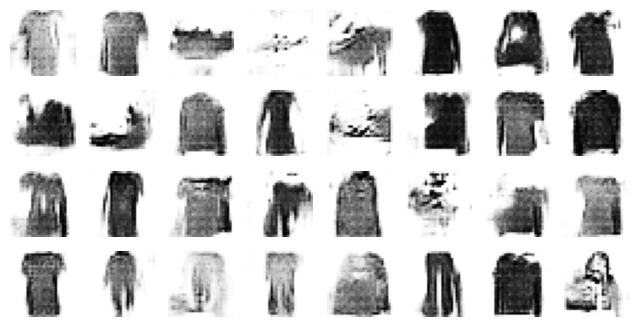

Epoch 2/5


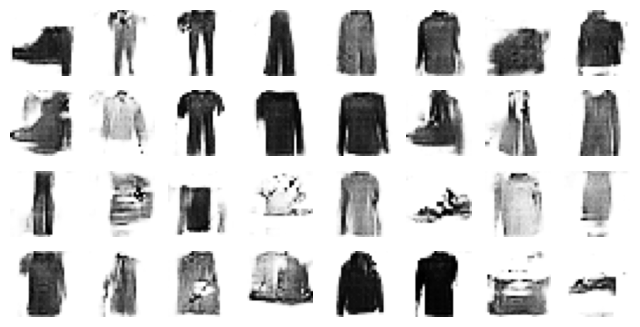

Epoch 3/5


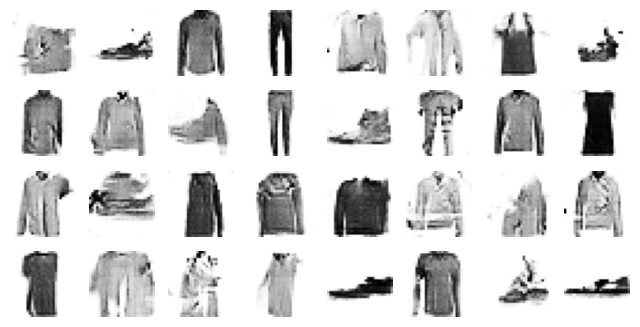

Epoch 4/5


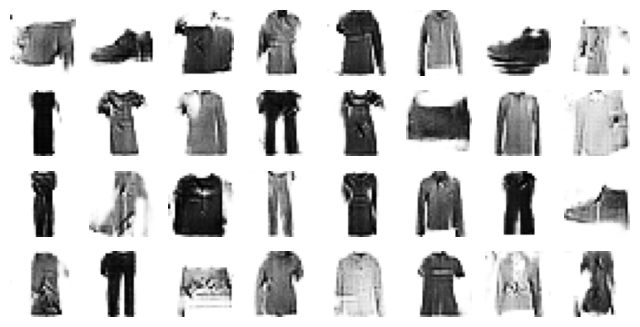

Epoch 5/5


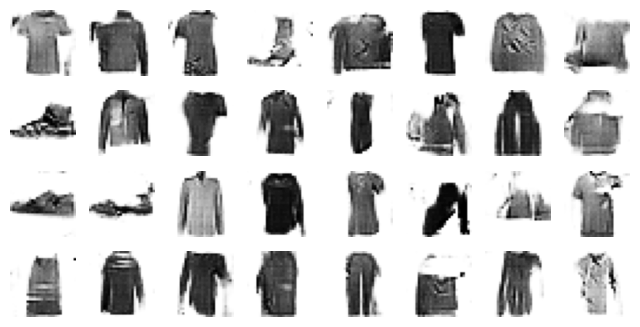

In [31]:
n = 5

train_gan(
    dcgan, dataset, batch_size, codings_size, n_epochs=n)

Wow! Much better.

## Generate Images with the Trained Generator

Use the trained DC generator to make images:

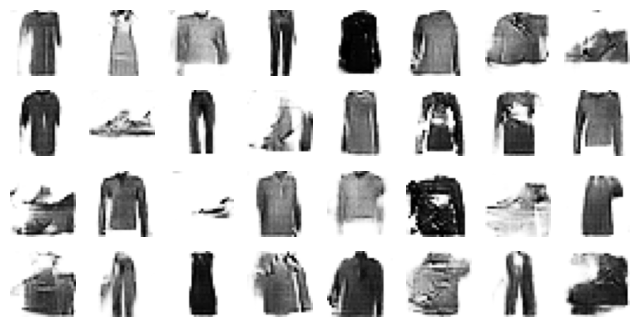

In [32]:
tf.random.set_seed(0)
np.random.seed(0)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = dc_generator(noise)
plot_multiple_images(generated_images, 8)

# Deep Convolutional GAN with Large Images

A very simple Deep Convolutional GAN worked well with Fashion-MNIST. But, images in this dataset are small and grayscale. Let's see how well a Deep Convolutional GAN works with the **rock_paper_scissors** dataset, which contains large color images of hands playing the rock, paper, scissor game.

Load the dataset to inspect its metadata:

In [ ]:
rps, info = tfds.load('rock_paper_scissors', with_info=True,
                      split='train', try_gcs=True)

Inspect:

In [ ]:
info

We now know the size of the train set, which is all that we need.  

Get the class labels and number of classes:

In [ ]:
num_classes = info.features['label'].num_classes
classes = info.features['label'].names
classes, num_classes

Visualize with **show_examples**:

In [ ]:
fig = tfds.show_examples(rps, info)

## Load the Dataset for Training

Load the dataset as numpy arrays:

In [ ]:
(x_train_img, _), (x_test_img, _) = tfds.as_numpy(
    tfds.load('rock_paper_scissors', split=['train','test'],
              batch_size=-1, as_supervised=True,
              try_gcs=True))

Inspect shapes:

In [ ]:
for element in range(10):
  print (x_train_img.shape)

The dataset contains 2,520 300 x 300 x 3 images. Since images are of the same size, we don't have to resize. However, we resize images for another reason later in this notebook.

## Shrink the Dataset

Shrink the dataset to a power of 2 to guarantee equal batches:

In [ ]:
x_train_rps = x_train_img[:2048]
len(x_train_rps)

## Reformat Images

Create a function to resize and scale images:

In [ ]:
IMAGE_RES = 256

def format_image(image):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image

Although we don't have to resize images, we do so to make it easier to create a model with the appropriate number of neurons.

Although images are all 300 x 300, resize to a power of 2 for convenience. Our generator begins by projecting relatively small images onto many dimensions with a large depth size and gradually increases image size and decreases depth size until it outputs the image size we want. So, it's easier to work with values divisible by and multiplicative of 2. Deep learning models also perform better when the number of neurons in a model are based on the power of 2.  

## Build the Input Pipeline

Create tensors from the feature images:

In [ ]:
train_slice = tf.data.Dataset.from_tensor_slices(x_train_rps)

Shuffle, reformat, batch, cache, and prefetch train data:

In [ ]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 500

train_rps = (train_slice.
             shuffle(SHUFFLE_SIZE).
             map(format_image).
             batch(BATCH_SIZE).
             cache().
             prefetch(1))
train_rps

Visualize images from a batch:

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_rps.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

## Build the Model

Clear models and generate a seed:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

Create the generator:

In [ ]:
codings_size = 100

gencolor = Sequential([
  Dense(32 * 32 * 256, input_shape=[codings_size]),
  Reshape([32, 32, 256]),
  BatchNormalization(),
  Conv2DTranspose(128, kernel_size=5, strides=2, padding='SAME',
                  activation='selu'),
  BatchNormalization(),
  Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME',
                  activation='selu'),
  BatchNormalization(),
  Conv2DTranspose(3, kernel_size=5, strides=2, padding='SAME',
                  activation='tanh'),
])

Notice that the number of neurons are based on the powers of 2 with one exception. The final layer contains three neurons to represent the number of classes.

Begin by feeding the generator a bit bigger (32 x 32) tensors projected to 256 dimensions resulting in a 262,144 dimensional space. The generator reshapes the projection to a 32 x 32 x 256 tensor, which is batch normalized and fed to a transposed convolutional layer with a stride of 2. The stride upsamples the tensor to 64 x 64 because it doubles the 32 x 32 dimension. The layer also reduces the tensor's depth from 256 to 128. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2. The stride upsamples it to 128 x 128 because it doubles the 64 x 64 dimension. The layer also reduces the tensor's depth from 128 to 64. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2. The stride upsamples it to 256 x 256 because it doubles the 128 x 128 dimension. The layer also reduces the tensor's depth from 64 to 3. The output tensor has shape (256, 256, 3), which is our goal because we resize images to 256 x 256 x 3. Since the final layer uses tanh activation, outputs are reshaped between the range -1 and 1.

Inspect:

In [ ]:
gencolor.summary()

Build the discriminator:

In [ ]:
discolor = Sequential([
  Conv2D(64, kernel_size=5, strides=2, padding='SAME',
         activation=LeakyReLU(0.2),
         input_shape=[256, 256, 3]),
  Dropout(0.4),
  Conv2D(128, kernel_size=5, strides=2, padding='SAME',
         activation=LeakyReLU(0.2)),
  Dropout(0.4),
  Flatten(),
  Dense(1, activation='sigmoid')
])

The discriminator accepts 256 x 256 x 3 images, downsamples tensors to 128 x 128, and increases depth from 32 to 64. Tensors are fed to a transposed convolutional layer, which downsamples tensors to 64 x 64 and increases depth to 128. The result is flattend to a 524,288 dimensional space (64 x 64 x 128). Since we are conducting binary classification, the final Dense layer includes **1** neuron.

Inspect:

In [ ]:
discolor.summary()

Create the DCGAN:

In [ ]:
dcgan_color = Sequential([gencolor, discolor])

## Compile:

Compile with **binary_crossentropy**:

In [ ]:
discolor.compile(
    loss='binary_crossentropy', optimizer='rmsprop')
discolor.trainable = False
dcgan_color.compile(
    loss='binary_crossentropy', optimizer='rmsprop')

## Rescale

Create a function to rescale:

In [ ]:
def rescale(image):
  image = tf.math.multiply(image, image * 2. -1)
  return image

Rescale images:

In [ ]:
train_color = train_rps.map(rescale)

## Model Data and Generate Images

Create a Function to plot images:

In [ ]:
def plot_color(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  images = np.clip(images, 0, 1)
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Create a function to train the GAN:

In [ ]:
def train_gan(
    gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(
          shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat(
          [generated_images, X_batch], axis=0)
      y1 = tf.constant(
          [[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(
          shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_color(generated_images, 8)
    plt.show()

Train:

In [ ]:
train_gan(
    dcgan_color, train_color, BATCH_SIZE, codings_size, 10)

Generated images are not produced satisfactorily because the generator and discriminator are much too simple. But, it's a start.